In [1]:
%load_ext autoreload
%autoreload 2

from tweedejaars_project import load_df
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import *
from sklearn.tree import *
from sklearn.metrics import *
from sklearn.linear_model import *


df = load_df()
df

,datetime,import_capacity,upward_dispatch_published,downward_dispatch_published,min_price_published,mid_price_published,max_price_published,minute_in_ptu,min_ptu_price_known,max_ptu_price_known,...,forecast_solar,forecast_demand,ptu_id,target_two_sided_ptu_alt,target_two_sided_ptu_realtime,target_two_sided_ptu_flip,fix_two_sided_ptu,fix_two_sided_ptu_alt,fix_two_sided_ptu_realtime,fix_two_sided_ptu_flip
0,2023-12-29 00:00:00+00:00,65.4,0.0,0.0,0.00,0.00,0.00,0,NaN,NaN,...,0.0,10927.409665,0,True,True,True,False,True,True,True
1,2023-12-29 00:01:00+00:00,65.4,0.0,0.0,0.00,0.00,0.00,1,NaN,NaN,...,0.0,10927.409665,0,True,False,False,False,True,False,False
2,2023-12-29 00:02:00+00:00,65.4,0.0,79.0,-8.81,33.59,NaN,2,-8.81,NaN,...,0.0,10927.409665,0,True,False,False,True,True,False,False
3,2023-12-29 00:03:00+00:00,65.4,0.0,61.0,-8.81,33.59,NaN,3,-8.81,NaN,...,0.0,10927.409665,0,True,False,False,True,True,False,False
4,2023-12-29 00:04:00+00:00,65.4,0.0,43.0,-8.81,33.59,NaN,4,-8.81,NaN,...,0.0,10927.409665,0,True,False,False,True,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
220241,2024-05-29 22:41:00+00:00,1982.6,167.0,0.0,NaN,80.12,96.92,11,NaN,101.22,...,0.0,11649.839443,14682,False,False,False,False,False,False,False
220242,2024-05-29 22:42:00+00:00,1982.6,165.0,0.0,NaN,80.12,96.92,12,NaN,101.22,...,0.0,11649.839443,14682,False,False,False,False,False,False,False
220243,2024-05-29 22:43:00+00:00,1982.6,162.0,0.0,NaN,80.12,96.87,13,NaN,101.22,...,0.0,11649.839443,14682,False,False,False,False,False,False,False
220244,2024-05-29 22:44:00+00:00,1982.6,158.0,0.0,NaN,80.12,96.87,14,NaN,101.22,...,0.0,11649.839443,14682,False,False,False,False,False,False,False


In [2]:
print(df.columns)

Index(['datetime', 'import_capacity', 'upward_dispatch_published',
       'downward_dispatch_published', 'min_price_published',
       'mid_price_published', 'max_price_published', 'minute_in_ptu',
       'min_ptu_price_known', 'max_ptu_price_known',
       'igcc_contribution_down_published', 'igcc_contribution_up_published',
       'settlement_price_bestguess', 'time_since_last_two_sided',
       'two_sided_daily_count', 'vwap_avg', 'vwap_std', 'vwap_median',
       'vwap_qty_sum', 'vwap_max', 'hvq_delta', 'PTU', 'target_two_sided_ptu',
       'settlement_price_realized', 'naive_strategy_action', 'forecast_wind',
       'forecast_solar', 'forecast_demand', 'ptu_id',
       'target_two_sided_ptu_alt', 'target_two_sided_ptu_realtime',
       'target_two_sided_ptu_flip', 'fix_two_sided_ptu',
       'fix_two_sided_ptu_alt', 'fix_two_sided_ptu_realtime',
       'fix_two_sided_ptu_flip'],
      dtype='object')


In [6]:
# Creating features

# forecast
df['residual_load'] = df['forecast_demand'] - df['forecast_solar'] - df['forecast_wind']
df['forecast_solar_delta'] = df['forecast_solar'].diff()
df['forecast_wind_delta'] = df['forecast_wind'].diff()

for i in range(0, len(df), 15):
    df.loc[i+1:i+14, 'forecast_solar_delta'] = df['forecast_solar_delta'][i]
    df.loc[i+1:i+14, 'forecast_wind_delta'] = df['forecast_wind_delta'][i]

# diffs
df['min_price_diff'] = df['min_price_published'].diff() + df['min_price_published']
df['downward_dispatch_diff'] = df['downward_dispatch_published'].diff() + df['downward_dispatch_published']
df['downward_dispatch_diff_2'] = df['downward_dispatch_published'].diff(periods=2) + df['downward_dispatch_published']
df['downward_dispatch_diff_3'] = df['downward_dispatch_published'].diff(periods=3) + df['downward_dispatch_published']
df['igcc_down_diff'] = df['igcc_contribution_down_published'].diff() + df['igcc_contribution_down_published']
df['dispatch_diff'] = df['upward_dispatch_published'] - df['downward_dispatch_published']
df['igcc_diff'] = df['igcc_contribution_up_published'] - df['igcc_contribution_down_published']

df['import_zero'] = df['import_capacity'] == 0
df['import_capacity_left'] = df['import_capacity'] + df['igcc_contribution_down_published'] - df['igcc_contribution_up_published']




    # df['import_capacity_left'] = 0
    # for i in range(1,len(df)):
    #     df.loc[i,'import_capacity_left'] = df['import_capacity_left'][i-1] + df['igcc_contribution_up_published'][i] - df['igcc_contribution_down_published'][i]

    # df.loc[i,'import_capacity_left'] = sum(df['igcc_contribution_up_published'][:i]) - sum(df['igcc_contribution_down_published'][:i])


# _ = features(df)


In [7]:
df['downward_dispatch_peak'] = False
df['downward_dispatch_peak_time'] = 0
df['downward_dispatch_peak_diff'] = 0
count = 0

val1 = df['downward_dispatch_published'][1]
val = df['downward_dispatch_published'][2]

for i in range(3,len(df)):
    val2 = val1
    val1 = val
    val = df['downward_dispatch_published'][i]
    if val2 < val1 > val:
        df.loc[i,'downward_dispatch_peak'] = True
        count = 0
        peakval = val1
    df.loc[i,'downward_dispatch_peak_time'] = count
    count += 1
    df.loc[i,'downward_dispatch_peak_diff'] = val - peakval

In [ ]:
df

,datetime,import_capacity,upward_dispatch_published,downward_dispatch_published,min_price_published,mid_price_published,max_price_published,minute_in_ptu,min_ptu_price_known,max_ptu_price_known,...,downward_dispatch_diff_2,downward_dispatch_diff_3,igcc_down_diff,dispatch_diff,igcc_diff,import_zero,import_capacity_left,downward_dispatch_peak,downward_dispatch_peak_time,downward_dispatch_peak_diff
0,2023-12-29 00:00:00+00:00,65.4,0.0,0.0,0.00,0.00,0.00,0,NaN,NaN,...,NaN,NaN,NaN,0.0,0.0,False,65.4,False,0,0.0
1,2023-12-29 00:01:00+00:00,65.4,0.0,0.0,0.00,0.00,0.00,1,NaN,NaN,...,NaN,NaN,0.0,0.0,0.0,False,65.4,False,0,0.0
2,2023-12-29 00:02:00+00:00,65.4,0.0,79.0,-8.81,33.59,NaN,2,-8.81,NaN,...,158.0,NaN,264.0,-79.0,-132.0,False,197.4,False,0,0.0
3,2023-12-29 00:03:00+00:00,65.4,0.0,61.0,-8.81,33.59,NaN,3,-8.81,NaN,...,122.0,122.0,-132.0,-61.0,30.0,False,35.4,True,0,-18.0
4,2023-12-29 00:04:00+00:00,65.4,0.0,43.0,-8.81,33.59,NaN,4,-8.81,NaN,...,7.0,86.0,0.0,-43.0,66.0,False,-0.6,False,1,-36.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
220241,2024-05-29 22:41:00+00:00,1982.6,167.0,0.0,NaN,80.12,96.92,11,NaN,101.22,...,0.0,0.0,0.0,167.0,104.0,False,1878.6,False,126,-6.0
220242,2024-05-29 22:42:00+00:00,1982.6,165.0,0.0,NaN,80.12,96.92,12,NaN,101.22,...,0.0,0.0,0.0,165.0,66.0,False,1916.6,False,127,-6.0
220243,2024-05-29 22:43:00+00:00,1982.6,162.0,0.0,NaN,80.12,96.87,13,NaN,101.22,...,0.0,0.0,0.0,162.0,99.0,False,1883.6,False,128,-6.0
220244,2024-05-29 22:44:00+00:00,1982.6,158.0,0.0,NaN,80.12,96.87,14,NaN,101.22,...,0.0,0.0,0.0,158.0,136.0,False,1846.6,False,129,-6.0


In [ ]:
df1 = df[['datetime','target_two_sided_ptu','minute_in_ptu','forecast_solar', 'forecast_solar_delta','forecast_wind','forecast_wind_delta','residual_load','min_price_published','mid_price_published','max_price_published']]
df2 = df[['minute_in_ptu','target_two_sided_ptu','min_price_published','mid_price_published','max_price_published','downward_dispatch_published','upward_dispatch_published','igcc_contribution_down_published','igcc_contribution_up_published']]
df3 = df[['igcc_contribution_down_published','igcc_contribution_up_published','import_capacity','import_capacity_left','import_zero','target_two_sided_ptu']]
df4 = df[['minute_in_ptu','target_two_sided_ptu','downward_dispatch_published','upward_dispatch_published','import_capacity','import_capacity_left']]

df4.head()

,minute_in_ptu,target_two_sided_ptu,downward_dispatch_published,upward_dispatch_published,import_capacity,import_capacity_left
0,0,False,0.0,0.0,65.4,65.4
1,1,False,0.0,0.0,65.4,65.4
2,2,True,79.0,0.0,65.4,197.4
3,3,True,61.0,0.0,65.4,35.4
4,4,True,43.0,0.0,65.4,-0.6


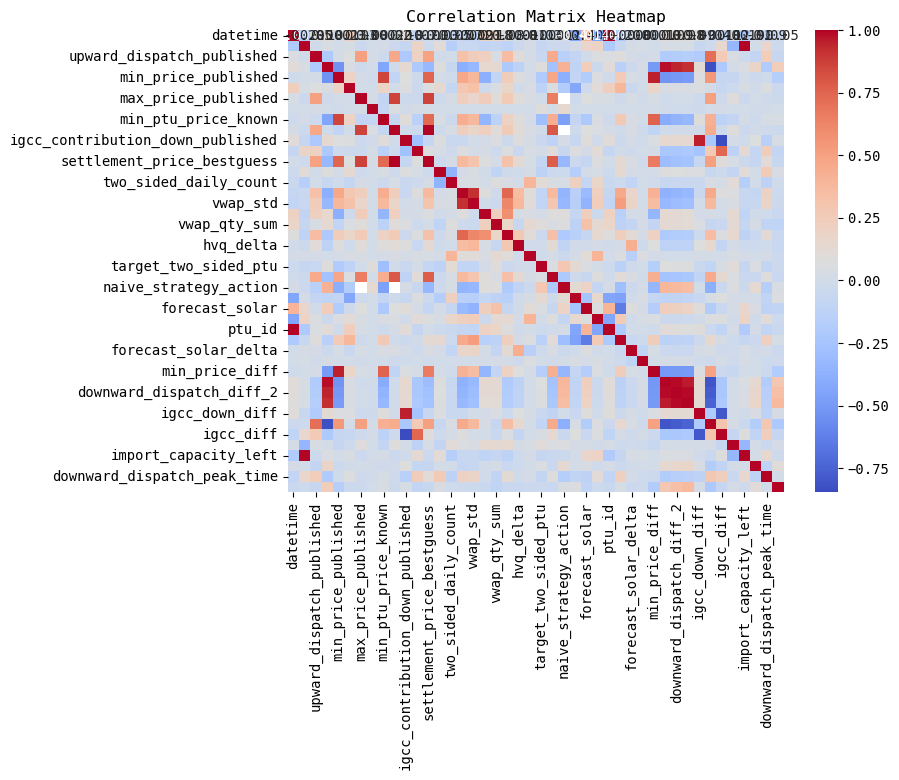

In [ ]:
correlation_matrix = df.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix Heatmap')
plt.show()

In [ ]:
# for i in range(0, len(df), 15):
#     df.loc[i+1:i+14, 'forecast_solar'] = np.nan
#     df.loc[i+1:i+14, 'forecast_wind'] = np.nan

# df['forecast_solar'] = df['forecast_solar'].interpolate(method='cubic')
# df['forecast_wind'] = df['forecast_wind'].interpolate(method='cubic')
# df['forecast_solar_delta'] = df['forecast_solar'].diff()
# df['forecast_wind_delta'] = df['forecast_wind'].diff()